In [31]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
from scipy.stats.stats import kendalltau
from scipy.stats import rankdata

path_prefix = "YOUR_PATH_HERE"

### BENCHMARK: PERFORMANCE

In [8]:
path = path_prefix + "data/performance/"
datasets = ["CIFAR10", "Sport8", "MIT67", "CIFAR100","Flowers102"]
methods = ["DARTS", "PDARTS", "NSGANET", "ENAS", "CNAS", "MANAS", "StacNAS", "NAO"]
data={}
for dataset in datasets:
    data[dataset] = pd.read_csv(path + dataset + ".csv")
data_Augmentation = pd.read_csv(path + "Augmentation.csv")

In [9]:
Random = {}
NAS = {}
X = {}
Y = {}
nb_repets = len(data[datasets[0]][methods[0]])
nb_methods = len(methods)
for dataset in datasets:
    Random[dataset] = [data[dataset].transpose().values[2*i] for i in range(nb_methods)]
    NAS[dataset] = [data[dataset].transpose().values[2*i+1] for i in range(nb_methods)]
    X[dataset]={}
    Y[dataset]={}
    X[dataset]["mean"] = [Random[dataset][i].mean() for i in range(nb_methods)]
    X[dataset]["min"] = [Random[dataset][i].min() for i in range(nb_methods)]
    X[dataset]["max"] = [Random[dataset][i].max() for i in range(nb_methods)]
    X[dataset]["std"] = [Random[dataset][i].std() for i in range(nb_methods)]
    Y[dataset]["mean"] = [NAS[dataset][i].mean() for i in range(nb_methods)]
    Y[dataset]["min"] = [NAS[dataset][i].min() for i in range(nb_methods)]
    Y[dataset]["max"] = [NAS[dataset][i].max() for i in range(nb_methods)]
    Y[dataset]["std"] = [NAS[dataset][i].std() for i in range(nb_methods)]
Y["CIFAR100"]["mean"][6] = 83.59
Y["CIFAR100"]["std"][6] = 0.47
Y["CIFAR100"]["min"][6] = 82.46
Y["CIFAR100"]["max"][6] = 83.87

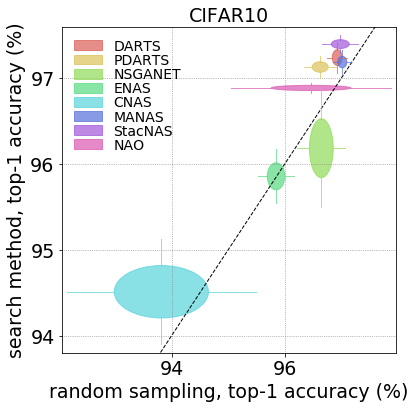

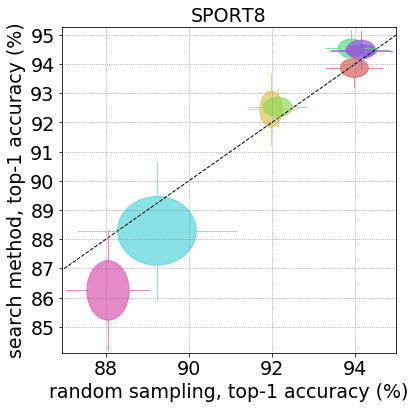

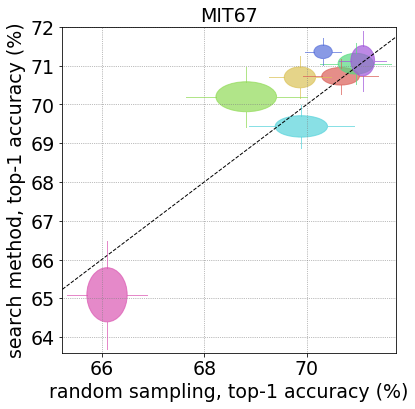

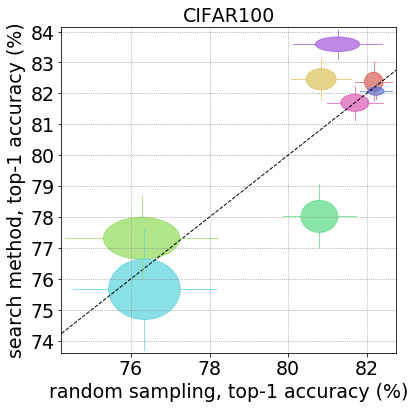

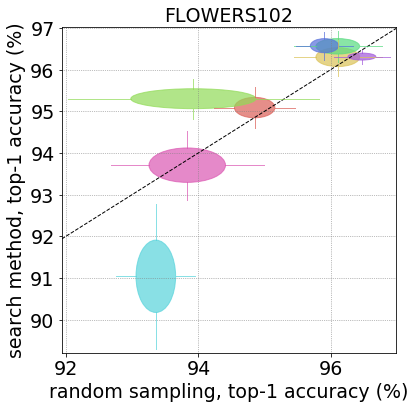

In [11]:
datasets_uppercase = {d: d.upper() for d in datasets}
current_palette = sns.color_palette("hls", nb_methods)
plt.rcParams["font.family"] = "DejaVu Sans"

v_offset = 0.1
v_alpha = 0.7

idx=0
NEW_SIZE=19
for dataset in datasets:
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, aspect='auto')
    ellipses=[]
    ax.plot([0,100],[0,100], linewidth=1 , color='black', linestyle="dashed", label="random architecture")
    xlim_lower = np.min(np.array(X[dataset]["mean"]) - np.array(X[dataset]["std"])) - v_offset
    xlim_upper = np.max(np.array(X[dataset]["mean"]) + np.array(X[dataset]["std"])) + v_offset
    ylim_lower = np.min(np.array(Y[dataset]["mean"]) - np.array(Y[dataset]["std"])) - v_offset
    ylim_upper = np.max(np.array(Y[dataset]["mean"]) + np.array(Y[dataset]["std"])) + v_offset
    for i in range(nb_methods):
        ellipse = Ellipse(xy=(X[dataset]["mean"][i], Y[dataset]["mean"][i]),
                          width=X[dataset]["std"][i], height=Y[dataset]["std"][i], 
                          label=methods[i], color=current_palette[i], alpha=v_alpha)
        plt.plot([ X[dataset]["mean"][i] - X[dataset]["std"][i]/2, X[dataset]["mean"][i] - X[dataset]["std"][i] ], [ Y[dataset]["mean"][i], Y[dataset]["mean"][i] ], linewidth=1, color=current_palette[i], alpha=v_alpha) # left
        plt.plot([ X[dataset]["mean"][i] + X[dataset]["std"][i]/2, X[dataset]["mean"][i] + X[dataset]["std"][i] ], [ Y[dataset]["mean"][i], Y[dataset]["mean"][i] ], linewidth=1, color=current_palette[i], alpha=v_alpha) # right
        plt.plot([ X[dataset]["mean"][i], X[dataset]["mean"][i] ], [ Y[dataset]["mean"][i] + Y[dataset]["std"][i]/2, Y[dataset]["mean"][i] + Y[dataset]["std"][i] ], linewidth=1, color=current_palette[i], alpha=v_alpha) # top
        plt.plot([ X[dataset]["mean"][i], X[dataset]["mean"][i] ], [ Y[dataset]["mean"][i] - Y[dataset]["std"][i]/2, Y[dataset]["mean"][i] - Y[dataset]["std"][i] ], linewidth=1, color=current_palette[i], alpha=v_alpha) # bottom
        ellipses.append(ellipse)
        ax.add_artist(ellipse)
    
    plt.xlabel("random sampling, top-1 accuracy (%)")
    plt.ylabel("search method, top-1 accuracy (%)")
    plt.title(datasets_uppercase[dataset], pad=5)
    plt.yticks(np.arange(math.floor(ylim_lower), math.ceil(ylim_upper)+1, 1.0))
    plt.grid(color='grey', linestyle=':', linewidth=0.7)
    plt.xlim([xlim_lower, xlim_upper])
    plt.ylim([ylim_lower, ylim_upper])
    if idx==0:
        ax.legend(ellipses, methods, loc='upper left', frameon=False, ncol=1, labelspacing=0.01, fontsize=NEW_SIZE-5) #, bbox_to_anchor=(0, -0.2), ncol=1)
    plt.rc('font', size=NEW_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=NEW_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=NEW_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=NEW_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=NEW_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=NEW_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=NEW_SIZE)  # fontsize of the figure title
    idx += 1
    
    plotname = "benchmarkPerf_" + dataset
    #plt.savefig(path_prefix + plotname + ".pdf")
    plt.show()


### BENCHMARK: PERFORMANCE AND COST

In [12]:
nm_methods = ['DARTS', 'StacNAS', 'PDARTS', 'MANAS', 'CNAS', 'NSGANET', 'NAO', 'ENAS']
nm_types = ['random', 'method', 'cost']
D_cifar10 = {'random': {'DARTS'   : [97.05, 96.85, 96.57, 97.09, 96.76, 97.10, 96.94, 97.02],
                        'StacNAS'  : [97.12, 97.07, 97.30, 97.24, 97.00, 97.00, 96.21, 96.87],
                        'PDARTS'  : [96.45, 96.69, 96.70, 96.89, 96.90, 96.65, 95.96, 96.73],
                        'MANAS'   : [96.77, 96.83, 96.91, 97.09, 97.28, 97.05, 96.99, 97.17],
                        'CNAS'    : [93.81, 95.21, 89.56, 94.32, 94.43, 94.87, 94.25, 94.11],
                        'NSGANET' : [97.07, 96.78, 96.49, 97.04, 97.08, 95.80, 96.28, 96.60],
                        'NAO'     : [97.01, 92.77, 96.76, 97.24, 97.23, 96.97, 96.94, 96.77],
                        'ENAS'    : [95.78, 95.64, 96.08, 95.12, 96.05, 95.99, 96.09, 96.00]},
             'method': {'DARTS'   : [97.47, 97.15, 97.41, 97.05, 96.93, 97.13, 97.40, 97.34],
                        'StacNAS'  : [97.35, 97.40, 97.35, 97.44, 97.24, 97.59, 97.29, 97.47],
                        'PDARTS'  : [97.05, 97.08, 96.93, 96.85, 97.21, 97.05, 97.31, 96.98],
                        'MANAS'   : [97.22, 97.06, 97.19, 96.91, 97.01, 97.28, 97.17, 97.17],
                        'CNAS'    : [94.79, 94.15, 94.60, 93.05, 95.09, 94.93, 94.66, 94.82],
                        'NSGANET' : [95.61, 96.29, 95.39, 95.67, 95.52, 96.67, 97.18, 97.11],
                        'NAO'     : [96.89, 96.94, 96.97, 96.79, 96.82, 96.83, 96.94, 96.87],
                        'ENAS'    : [95.64, 96.10, 95.18, 95.84, 96.32, 95.95, 95.86, 95.94]},
             'cost': {  'DARTS'   : 0.3,
                        'StacNAS'  : 1,
                        'PDARTS'  : 0.25,
                        'MANAS'   : 0.7,
                        'CNAS'    : 0.6,
                        'NSGANET' : 4,
                        'NAO'     : 0.67,
                        'ENAS'    : 0.3}}
datasets = {'cifar10' : D_cifar10}

In [13]:
means_r = [np.mean(datasets['cifar10']['random'][i]) for i in nm_methods]
means_m = [np.mean(datasets['cifar10']['method'][i]) for i in nm_methods]
means_c = [datasets['cifar10']['cost'][i] for i in nm_methods]
sds_r = [np.std(datasets['cifar10']['random'][i]) for i in nm_methods]
sds_m = [np.std(datasets['cifar10']['method'][i]) for i in nm_methods]
sds_c = [0 for i in nm_methods]
x_pos = np.arange(len(nm_methods))

In [14]:
data = {'random_means': means_r, 'method_means': means_m, 'cost_means': means_c,
        'random_sds': sds_r, 'method_sds': sds_m, 'cost_sds': sds_c}
df = pd.DataFrame(data, index=nm_methods)
order_by = "method"  # { "method", "random", "cost"}
order_by_colname = 'method_means' if order_by=="method" else 'random_means' if order_by=="random" else 'cost_means' if order_by=="cost" else None
order_by_label = 'search method accuracy' if order_by=="method" else 'random sampling accuracy' if order_by=="random" else 'cost' if order_by=="cost" else None
df = df.sort_values([order_by_colname], ascending=[True])
# trick to make labels neater
method_labels = list(df.index)
max_len = max([len(method_labels[i]) for i in range(len(method_labels))])
for i in range(len(method_labels)):
    method_labels[i] = method_labels[i].rjust(max_len, ' ') 

<Figure size 432x360 with 0 Axes>

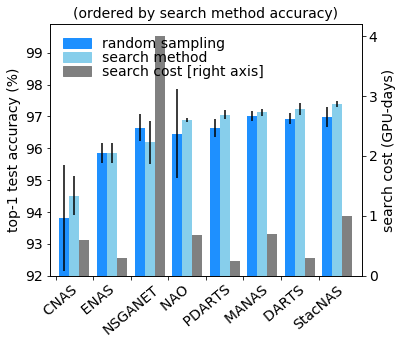

In [15]:
legend_colors = ['dodgerblue','skyblue','grey']
legend_labels = ['random sampling', 'search method', 'search cost [right axis]']
legend_patches = [mpatches.Patch(color=legend_colors[i], label=legend_labels[i]) for i in range(3)]
plot_name = 'cifar10_perfVScost'

f = plt.figure(figsize=(6,5))
plt.rcParams["font.family"] = "DejaVu Sans"
NEW_SIZE=14
plt.rc('font', size=NEW_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=NEW_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=NEW_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=NEW_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=NEW_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=NEW_SIZE)    # legend fontsize
plt.rc('figure', titlesize=NEW_SIZE)  # fontsize of the figure title
ax = df[['random_means','method_means','cost_means']].plot(kind='bar', secondary_y=['cost_means'], legend=False, rot=40, 
        width=0.8, figsize=(6,5), ylim=(92,99.9), yerr=df[['random_sds','method_sds','cost_sds']].values.T, color=legend_colors, alpha=1, fontsize=NEW_SIZE)
ax.set_ylabel('top-1 test accuracy (%)', fontsize=NEW_SIZE)
ax.right_ax.set_ylabel('search cost (GPU-days)', fontsize=NEW_SIZE)
plt.xticks(np.array(-0.5) + np.arange(0, 8, 1), method_labels, fontsize=NEW_SIZE)
plt.legend(handles=legend_patches, loc='upper left', frameon=False, ncol=1, labelspacing=0.01, fontsize=NEW_SIZE) #bbox_to_anchor=(0.5, -0.25),
plt.title("(ordered by {})".format(order_by_label))
plt.tight_layout()

#plt.savefig(path_prefix + plotname + ".pdf", bbox_inches='tight')
plt.show()


### BENCHMARK: RELATIVE IMPROVEMENT OVER RANDOM

In [16]:
nm_datasets = ["CIFAR10", "CIFAR100", "Sport8", "MIT67","Flowers102"]
nb_datasets = len(nm_datasets)
nm_methods = ["DARTS", "PDARTS", "NSGANET", "ENAS", "CNAS", "MANAS", "StacNAS", "NAO"]
pd_res = pd.DataFrame(columns=nm_datasets, index=nm_methods)
for dataset in nm_datasets:
    for method in range(nb_methods):
        val = 100 * (Y[dataset]['mean'][method] - X[dataset]['mean'][method]) / X[dataset]['mean'][method]
        pd_res[dataset][nm_methods[method]] = round(val,2)
print(pd_res)

        CIFAR10 CIFAR100 Sport8 MIT67 Flowers102
DARTS      0.32     0.23  -0.13   0.1       0.25
PDARTS     0.52        2   0.51  1.19        0.2
NSGANET   -0.48     1.37   0.43     2       1.47
ENAS       0.01    -3.44   0.67  0.13       0.47
CNAS       0.74    -0.89  -1.06 -0.66      -2.48
MANAS      0.18     -0.2   0.33  1.48        0.7
StacNAS    0.43     2.87   0.38  0.05      -0.16
NAO        0.44    -0.01  -2.05 -1.53      -0.13


### AUGMENTATION TRICKS

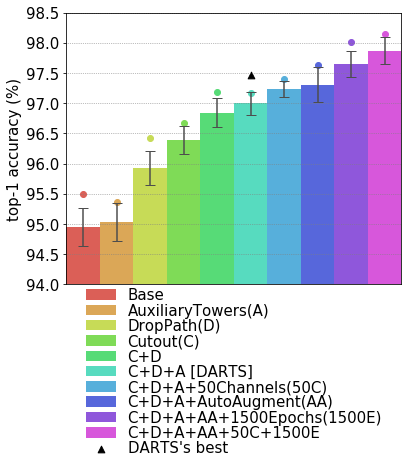

In [18]:
dataset = "CIFAR10"
lims = [94,99]
bar_width = 1
error_config = {'ecolor': '0.3'}
configurations = ["Base", "AuxiliaryTowers(A)", "DropPath(D)", "Cutout(C)", "C+D", "C+D+A [DARTS]", "C+D+A+50Channels(50C)", "C+D+A+AutoAugment(AA)", "C+D+A+AA+1500Epochs(1500E)", "C+D+A+AA+50C+1500E"]
points = ["DARTS's best"]
nb_configurations = len(configurations)
nb_points = len(points)
current_palette = sns.color_palette("hls", nb_configurations+nb_points)
plotname = "benchmarkTricks"

f = plt.figure(figsize=(6,5))
NEW_SIZE = 15
plt.rc('font', size=NEW_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=NEW_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=NEW_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=NEW_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=NEW_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=NEW_SIZE)    # legend fontsize
plt.rc('figure', titlesize=NEW_SIZE)  # fontsize of the figure title

lines = {}
plt.grid(color='grey', linestyle=':', linewidth=0.7)
for i in range(nb_configurations):
    lines[i] = plt.bar(bar_width*i, 
                       data_Augmentation.mean().values[i], 
                       bar_width,
                       alpha=1, 
                       color=current_palette[i],
                       yerr=data_Augmentation.std().values[i], 
                       error_kw=error_config, 
                       label=configurations[i], 
                       capsize=5)
    plt.scatter(bar_width*i, data_Augmentation.max().values[i], label="Best %s" % configurations[i], color=current_palette[i])
darts = plt.scatter(bar_width*5, 97.47, label = "DARTS", marker = "^", color='black', s=45)

plt.ylabel("top-1 accuracy (%)")
plt.margins(0.1,0)
plt.ylim(lims)
plt.xlim([-0.5, 9.5])
plt.ylim([94, 98.5])
plt.xticks([])
plt.legend([v for v in lines.values()]+[darts], configurations+points, loc='lower center', bbox_to_anchor=(0.5, -0.68), 
           ncol=1, fontsize=NEW_SIZE, labelspacing=0.02, frameon=False)

#plt.savefig(path_prefix + plotname + "2.pdf", bbox_inches='tight')
plt.show()

### Random architectures: training

In [19]:
path = path_prefix + "data/modified_search_space/"
rnd_archs = np.load(path + "214_random_architectures.npy")
n_epochs = len(rnd_archs[0])
n_curves = len(rnd_archs)
xx = list(range(n_epochs))

rnd_archs_MEAN = [np.mean([rnd_archs[j][i] for j in range(n_curves)]) for i in range(n_epochs)]
rnd_archs_END = [rnd_archs[i].max() for i in range(n_curves)]
MID_point_1 = 300
rnd_archs_MID1 = [rnd_archs[i][MID_point_1-1] for i in range(n_curves)]
MID_point_2 = 450
rnd_archs_MID2 = [rnd_archs[i][MID_point_2-1] for i in range(n_curves)]

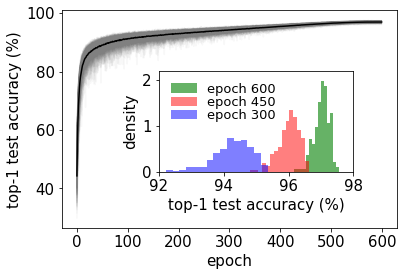

In [20]:
fig, ax1 = plt.subplots(figsize=(6,4))
# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.35, 0.32, 0.45, 0.35]

NEW_SIZE = 15
plt.rc('font', size=NEW_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=NEW_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=NEW_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=NEW_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=NEW_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=NEW_SIZE)    # legend fontsize
plt.rc('figure', titlesize=NEW_SIZE)  # fontsize of the figure title
plotname = "benchmarkTraining"

current_palette = sns.color_palette("hls", 8)
for i in range(n_curves):
    ax1.plot(xx, rnd_archs[i], color='grey', alpha=0.05)
ax1.plot(xx, rnd_archs_MEAN, color='black')
ax1.set_xlabel('epoch')
ax1.set_ylabel('top-1 test accuracy (%)')
ax2 = fig.add_axes([left, bottom, width, height])
ax2.hist(rnd_archs_END, density=True, histtype="stepfilled", color='green', bins=15, rwidth=0.9, alpha=0.6)
ax2.hist(rnd_archs_MID2, density=True, histtype="stepfilled", color='red', bins=15, rwidth=0.9, alpha=0.5)
ax2.hist(rnd_archs_MID1, density=True, histtype="stepfilled", color='blue', bins=15, rwidth=0.9, alpha=0.5)
#ax2.set_xlim([95.75,97.75])
ax2.set_xlim([92,98])
ax2.set_ylim([0,2.2]) #[0,int(ax2.viewLim.y1+1)]
#ax2.set_title('accuracy at epoch 600')
ax2.set_xlabel('top-1 test accuracy (%)')
ax2.set_ylabel('density')
ax2.legend(['epoch 600', 'epoch %d' % MID_point_2, 'epoch %d' % MID_point_1], loc='upper left', frameon=False, ncol=1, labelspacing=0.01, fontsize=NEW_SIZE-2) #bbox_to_anchor=(0.5, -0.25),

#plt.savefig(path_prefix + plotname + ".pdf", bbox_inches='tight')
plt.show()

### Random architectures: correlation

In [21]:
path = path_prefix + "data/modified_search_space/"
rnd_archs = np.load(path + "214_random_architectures.npy")
n_epochs = len(rnd_archs[0])
n_curves = len(rnd_archs)
xx = list(range(n_epochs))

rnd_archs_END = [rnd_archs[i][n_epochs-1] for i in range(n_curves)]
# {spearmanr, pearsonr, kendalltau}
rnd_archs_COR = [kendalltau([rnd_archs[j][i] for j in range(n_curves)], rnd_archs_END) for i in range(n_epochs)]
rnd_archs_COR = [rnd_archs_COR[i][0] for i in range(n_epochs)]

N = 20
rnd_archs_smooth = [np.convolve([rnd_archs[i][j] for j in range(n_epochs)], np.ones((N,))/N, mode='valid') for i in range(n_curves)]
rnd_archs_COR_smooth = [kendalltau([rnd_archs_smooth[j][i] for j in range(n_curves)], rnd_archs_END) for i in range(n_epochs-N+1)]
rnd_archs_COR_smooth = [rnd_archs_COR_smooth[i][0] for i in range(n_epochs-N+1)]

#cor_xlim = [96.25, 97.5]

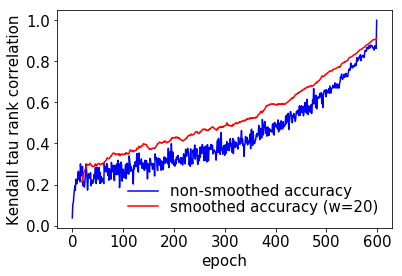

In [22]:
f = plt.figure(figsize=(6,4))
NEW_SIZE = 15
plt.rc('font', size=NEW_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=NEW_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=NEW_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=NEW_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=NEW_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=NEW_SIZE)    # legend fontsize
plt.rc('figure', titlesize=NEW_SIZE)  # fontsize of the figure title
plotname = "benchmarkCorrelationTraining"

plt.plot(xx, rnd_archs_COR, color='blue')
plt.plot(xx[N-1:n_epochs], rnd_archs_COR_smooth, color='red')
plt.xlabel("epoch")
plt.ylabel("Kendall tau rank correlation")
plt.legend(['non-smoothed accuracy','smoothed accuracy (w={})'.format(N)], loc='lower right', frameon=False, ncol=1, labelspacing=0.01, fontsize=NEW_SIZE) #bbox_to_anchor=(0.5, -0.25),

#plt.savefig(path_prefix + plotname + ".pdf", bbox_inches='tight')
plt.show()

### Different Cells

In [23]:
path = path_prefix + "data/cell_sensitivity/"
cell_list = [4,6,8,12,16,20,24]

res = {}
for c in cell_list:
    valids = np.load("{}/cell_n_{}.npy".format(path, c))
    res[c] = (valids.max(axis=1).mean(), valids.max(axis=1).std(), valids.max())
    print(valids.shape, end=' ')

mean_v, std_v, max_v = [], [], []
l = len(cell_list)
for c in cell_list:
    t = res[c]
    mean_v.append(t[0])
    std_v.append(t[1])
    max_v.append(t[2])

(16, 600) (12, 600) (15, 600) (16, 600) (16, 600) (16, 600) (16, 600) 

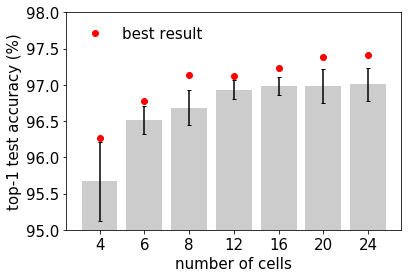

In [24]:
f = plt.figure(figsize=(6,4))
NEW_SIZE = 15
plt.rc('font', size=NEW_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=NEW_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=NEW_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=NEW_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=NEW_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=NEW_SIZE)    # legend fontsize
plt.rc('figure', titlesize=NEW_SIZE)  # fontsize of the figure title
plotname = "benchmarkCellSensitivity"

plt.bar(range(l), mean_v, yerr=std_v, capsize=2, color='grey', alpha=0.4)
plt.plot(range(l), max_v, 'o', color='red')
plt.xticks(range(l), cell_list)
plt.ylim([95,98])
plt.xlabel("number of cells")
plt.ylabel("top-1 test accuracy (%)")
plt.legend(['best result'], loc='upper left', frameon=False, ncol=1, labelspacing=0.01, fontsize=NEW_SIZE)

#plt.savefig(path_prefix + plotname + ".pdf", bbox_inches='tight')
plt.show()

### CORRELATIONS BETWEEN CELLS

In [25]:
path = path_prefix + "data/correlation_cells"
results = np.load("{}/8_to_20_cells.npy".format(path))

rank_8 = rankdata(results[:,0])
rank_20 = rankdata(results[:,1])
kendall_cells = kendalltau(results[:,0], results[:,1]).correlation

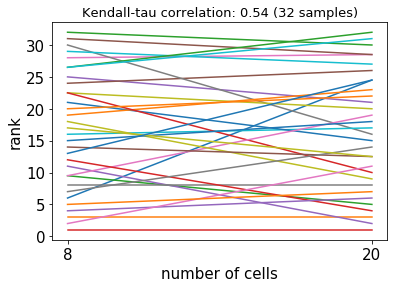

In [26]:
f = plt.figure(figsize=(6,4))
NEW_SIZE = 15
plt.rc('font', size=NEW_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=NEW_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=NEW_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=NEW_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=NEW_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=NEW_SIZE)    # legend fontsize
plt.rc('figure', titlesize=NEW_SIZE)  # fontsize of the figure title
plotname = "benchmarkCorrelationCells"

n_xpers = results.shape[0]
for i in range(n_xpers):
    points = [rank_8[i], rank_20[i]]
    plt.plot([8,20], points)

plt.xticks([8,20])
plt.xlabel("number of cells")
plt.ylabel("rank")
plt.title("Kendall-tau correlation: %.2f (%d samples)" % (kendall_cells, n_xpers), size=NEW_SIZE-2)

#plt.savefig(path_prefix + plotname + ".pdf", bbox_inches='tight')
plt.show()

### CORRELATIONS BETWEEN SEEDS

In [27]:
path = path_prefix + "data/correlation_seeds/"
A = np.load(path + "different_seed_24.npy")
B = np.array([[97.15, 97],[96.93, 97.02],[96.77, 96.71],[97.16, 96.8],[96.66, 97.05],[97.04, 97.09],[97.11, 97.05],[97.17, 97.19]])
corr_seeds = np.vstack([A, B])

kendall_seeds = kendalltau(corr_seeds[:,0], corr_seeds[:,1]).correlation
rank_a = rankdata(corr_seeds[:,0])
rank_b = rankdata(corr_seeds[:,1])

#(abs(corr_seeds[:,0] - corr_seeds[:,1])).mean()

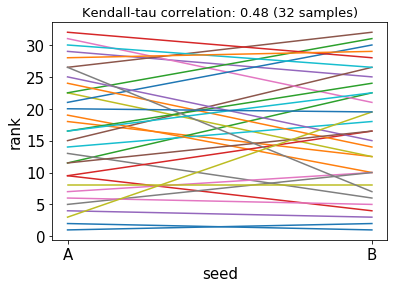

In [28]:
f = plt.figure(figsize=(6,4))
NEW_SIZE = 15
plt.rc('font', size=NEW_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=NEW_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=NEW_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=NEW_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=NEW_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=NEW_SIZE)    # legend fontsize
plt.rc('figure', titlesize=NEW_SIZE)  # fontsize of the figure title
plotname = "benchmarkCorrelationSeeds"

for i in range(corr_seeds.shape[0]):
    points = [rank_a[i], rank_b[i]]
    plt.plot([0,1], points)

plt.xticks(ticks=[0,1], labels=['A', 'B'])
plt.xlabel("seed")
plt.ylabel("rank")
plt.title("Kendall-tau correlation: %.2f (%d samples)" % (kendall_seeds, corr_seeds.shape[0]), size=NEW_SIZE-2)

#plt.savefig(path_prefix + plotname + ".pdf", bbox_inches='tight')
plt.show()

### MODIFIED SEARCH SPACE

In [29]:
path = path_prefix + "data/modified_search_space/"
epoch = 600
data_original = np.load(path + "214_random_architectures.npy")
data_original = [data_original[i].max() for i in range(len(data_original))]
data_modified = np.load(path + "56_random_mod_architectures.npy")
data_modified = [data_modified[i].max() for i in range(len(data_modified))]

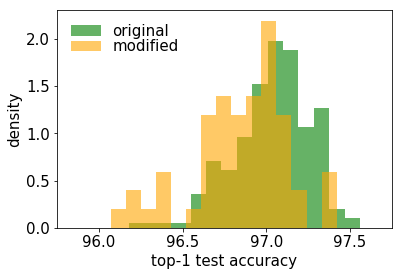

In [30]:
f = plt.figure(figsize=(6,4))
NEW_SIZE = 15
plt.rc('font', size=NEW_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=NEW_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=NEW_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=NEW_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=NEW_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=NEW_SIZE)    # legend fontsize
plt.rc('figure', titlesize=NEW_SIZE)  # fontsize of the figure title
plotname = "benchmarkModSearchSpace"

plt.hist(data_original, density=True, histtype="stepfilled", color='green', bins=15, rwidth=1, alpha=0.6)
plt.hist(data_modified, density=True, histtype="stepfilled", color='orange', bins=15, rwidth=1, alpha=0.6)
plt.xlim([95.75,97.75])
plt.ylim([0,2.3])
plt.xlabel("top-1 test accuracy")
plt.ylabel("density")
plt.legend(['original', 'modified'], loc='upper left', frameon=False, ncol=1, labelspacing=0.01, fontsize=NEW_SIZE)

#plt.savefig(path_prefix + plotname + ".pdf", bbox_inches='tight')
plt.show()